In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
Dataset = JHUDataset()

def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 3.2
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        #'projection_iterations': 25, # Number of iterations into the future to project
        'projection_iterations': 60, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        'incubation_period': 5, # In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'use_harvard_init': use_harvard_init, #If True use the harvard model inputs for inital conditions and N (recreate their graph)

        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': True, #If True use the parameters that make R0 2.4, if not calculate off the above
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'total_infected_period': 12, # In days
        'duration_mild_infections': 10, # In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'case_fatality_rate': .0109341104294479,
        'beta': 0.24,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,
        #'model': 'sir',
        'model': 'seir',
    }
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.35,
        datetime.date(2020, 5, 18): r0
    },
    {  # test intervention with small changes to make sure format works
        datetime.date(2020, 4, 3): 10,
    },
    {
        datetime.date(2020, 3, 23): 1000,
    },
]

In [5]:
# Dataset.get_timeseries_by_country_state('USA', 'TX', 1)[['date','cases','deaths','recovered','active']]

Dataset.get_beds_by_country_state('USA', 'NY')

52525

In [6]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [7]:
# Params with True
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000

# params with False
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 28995881.0

In [8]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24707 entries, 0 to 24706
Data columns (total 8 columns):
index        24707 non-null int64
date         24707 non-null datetime64[ns]
country      24707 non-null object
state        20619 non-null object
county       16784 non-null object
cases        24688 non-null float64
deaths       24266 non-null float64
recovered    24319 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 1.5+ MB
{"beta": [0.0, 1.2829359524935329e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.2, "gamma": [0.0, 0.133, 0.125, 0.075], "rho": [0.0, 0.033, 0.042], "mu": 0.05}
2.399991458380972
new R0: 10.000039044207266
{"beta": [0.0, 5.6339260094853e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.2, "gamma": [0.0, 0.133, 0.125, 0.075], "rho": [0.0, 0.033, 0.042], "mu": 0.05}
date           2020-11-20 00:00:00
dead                     590274.79
exposed                       0.00
infected        

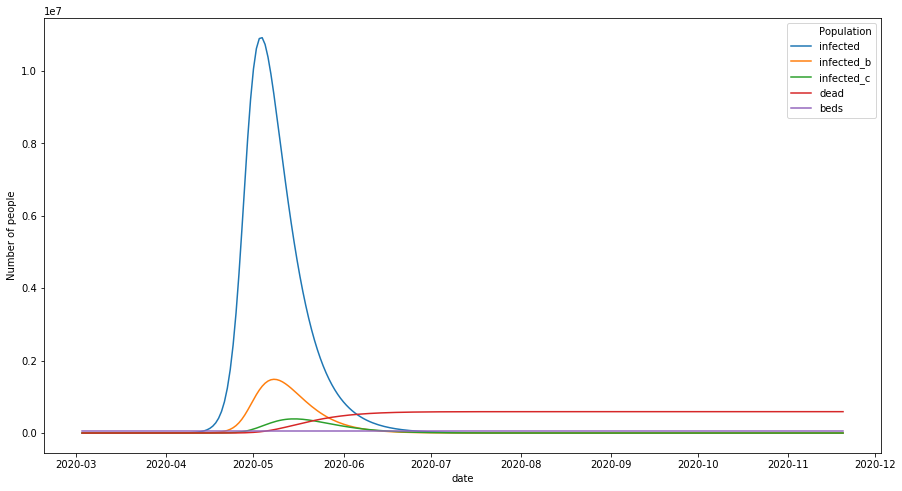

In [9]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[4])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

In [10]:
#initervention_df.describe()

,dead,exposed,infected,infected_a,infected_b,infected_c,recovered,susceptible,total,beds
count,264.00,264.00,264.00,264.00,264.00,264.00,264.00,264.00,264.00,264.00
mean,410174.97,558978.26,851302.99,673500.28,133085.95,44716.75,20870188.77,6305236.00,28995881.00,66691.00
std,253417.97,1928209.99,2318351.81,1944386.79,340864.44,100125.12,11588966.00,11375619.93,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,78333.05,28995881.00,66691.00
25%,73464.56,0.03,0.49,0.13,0.07,0.25,14585882.19,363156.33,28995881.00,66691.00
50%,588222.38,50.64,833.07,252.11,98.12,67.87,28033494.98,366134.34,28995881.00,66691.00
75%,590273.31,18546.45,96601.53,46545.66,17437.66,14542.10,28039466.55,366136.67,28995881.00,66691.00
max,590274.79,11277288.38,10920044.01,9546004.41,1483969.61,390756.71,28039469.54,28995881.00,28995881.00,66691.00


In [11]:
#print(initervention_df.loc[21:].head(25))

0.3719985820912413

{"beta": [0.0, 1.2829359524935329e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.2, "gamma": [0.0, 0.133, 0.125, 0.075], "rho": [0.0, 0.033, 0.042], "mu": 0.05}
2.399991458380972
new R0: 1.1000004426818697
{"beta": [0.0, 5.386974566670017e-09, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.2, "gamma": [0.0, 0.133, 0.125, 0.075], "rho": [0.0, 0.033, 0.042], "mu": 0.05}
new R0: 0.8000225378678544
{"beta": [0.0, 3.6696157390790726e-09, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.2, "gamma": [0.0, 0.133, 0.125, 0.075], "rho": [0.0, 0.033, 0.042], "mu": 0.05}
new R0: 2.399991458380972
{"beta": [0.0, 1.2829359524935329e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.2, "gamma": [0.0, 0.133, 0.125, 0.075], "rho": [0.0, 0.033, 0.042], "mu": 0.05}
date           2020-11-20 00:00:00
dead                     590274.79
exposed                       0.00
infected                      0.00
infected_a                    0.00
infected_b  

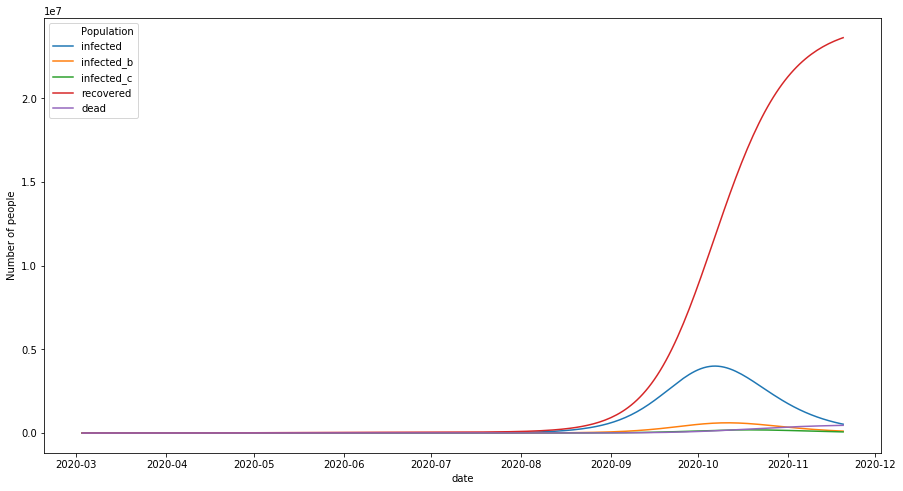

In [12]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[1])
    
print(initervention_df.iloc[-1])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
#chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
plot_df(df, chart_cols)

[1.28784421e+08 1.55169936e+08 3.06621959e+07 1.03024988e+07
 6.23697040e+09 1.24577701e+08]
(365, 6)


(1, 28995881.0)

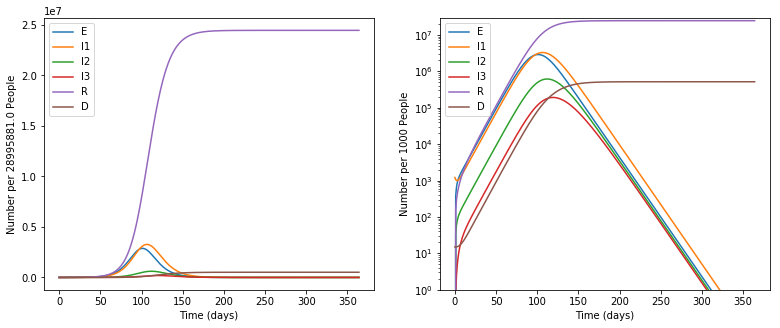

In [13]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N =  28995881.00
    #N = 10000
    tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel(f"Number per {str(N)} People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

plt.ylim([1,N])
#plt.tight_layout()